## 手写RNN

In [2]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
# one-hot编码，第一个参数是类别，第二个参数是向量长度。
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [5]:
# 小批量数据形式是（批量大小，时间步数）
X = torch.arange(10).reshape((2, 5))
# 转置之后时间步数在第一维，方便查看
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### 初始化RNN模型参数

In [6]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def nomal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    W_xh = nomal((num_inputs, num_hiddens))
    W_hh = nomal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = nomal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [7]:
# 初始化0时刻的隐藏状态
def init_rnn_state(batch_size, num_hiddens, device):
    # 返回一个tuple是为了后面写lstm形式统一
    return (torch.zeros((batch_size, num_hiddens), device=device), )

### 定义RNN的模型计算

In [8]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # 遍历时间步数维度
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    # (batch_size × 时间步长，vocab长度)
    return torch.cat(outputs, dim=0), (H,)

In [9]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [10]:
# 进行一次运算检查输出是否有正确形状
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
# Y是(bacth_size*num_step, vocab_size)
# new_state是(batch_size*num_hiddens)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### 定义预测函数
其中的prefix是一个用户提供的包含多个字符的字符串。
在循环遍历prefix中的开始字符时，不断地将隐状态传递到下一个时间步，但是不生成任何输出。
这被称为预热（warm-up）期，因为在此期间模型会自我更新（例如，更新隐状态），但不会进行预测。
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，从而预测字符并输出它们。

In [47]:
# 生成prefix之后的新字符
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    # vocab[prefix[0]]是拿到下标
    outputs = [vocab[prefix[0]]]
    # outputs[-1]是最近预测的词，要作为下一时刻输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # warm-up
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [48]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller qusvjtousv'

### 梯度剪裁

In [49]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 定义训练函数
它以前训练的方式有三个不同之处。

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
1. 在更新模型参数之前裁剪梯度。
   这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 用困惑度来评价模型。这样的度量确保了不同长度的序列具有可比性。

In [50]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        # 当使用顺序分区时，只在每个迭代周期的开始位置初始化隐状态。
        # 由于下一个小批量数据中的第i个子序列样本与当前第i个子序列样本相邻，
        # 因此当前小批量数据最后一个样本的隐状态将用于初始化下一个小批量数据第一个样本的隐状态。
        # 这样，存储在隐状态中的序列的历史信息可以在一个迭代周期内流经相邻的子序列。
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 为降低计算量，在处理任何一个小批量数据之前先分离梯度，
            # 使得隐状态的梯度计算总限制在一个小批量数据时间步内。
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    # 困惑度
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [51]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

### 查看预测效果 连续抽样 or 随机抽样

困惑度 1.1, 26175.5 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


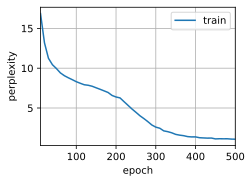

In [52]:
num_epochs, lr = 500, 0.5
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.7, 38000.0 词元/秒 cuda:0
time traveller proceeded anyreal body musp have in a sored you k
traveller after the pauserequired for the mist roall therec


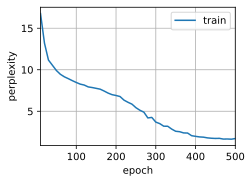

In [56]:
num_epochs, lr = 500, 0.5
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)